In [236]:
import numpy as np
import pandas as pd
import arviz as az
import scipy.stats as stats
import pymc as pm
import matplotlib.pyplot as plt

In [2]:
zone_entries = pd.read_csv('zone_entries.csv')
shifts_df = pd.read_csv('BDC_2024_Womens_Shifts.csv')
players_to_remove = ['Aerin Frankel', 'Emerance Maschmeyer', 'Kristen Campbell', 'Nicole Hensley', 'Ann-Renee Desbiens']
shifts_df = shifts_df[~shifts_df['player_name'].isin(players_to_remove)]

# Find unique combinations of game_id and period
unique_game_periods = zone_entries[['Date', 'Period']].drop_duplicates()

In [3]:
def time_left_to_seconds(time_str):
    minutes, seconds = map(int, time_str.split(':'))
    return (20 - minutes) * 60 + (0 - seconds)

def create_on_ice_matrix(df, Date, period):
    # Filter the DataFrame for the specific game and period
    game_period_df = df[(df['Date'] == Date) & (df['period'] == period)].copy()
    
    # Convert the start and end times to elapsed seconds from the start of the period
    game_period_df['start_elapsed'] = game_period_df['start_clock'].apply(time_left_to_seconds)
    game_period_df['end_elapsed'] = game_period_df['end_clock'].apply(time_left_to_seconds)
    
    # Create a timeline from 0 to 20*60 seconds for the period
    timeline = range(0, 20*60)
    
    # Create an empty DataFrame with the timeline as index and players as columns
    columns = game_period_df['player_name'].unique()
    on_ice_matrix = pd.DataFrame(0, index=timeline, columns=columns)
    
    # Fill the matrix for each player's shift
    for _, row in game_period_df.iterrows():
        on_ice_matrix.loc[row['start_elapsed']:row['end_elapsed'], row['player_name']] = 1
    
    # Add Date and period columns
    on_ice_matrix['Date'] = Date
    on_ice_matrix['Period'] = period
    on_ice_matrix["timeline"] = timeline
    
    return on_ice_matrix



In [4]:
all_matrices = []

# Iterate over each unique combination and apply the function
for _, row in unique_game_periods.iterrows():
    date = row['Date']
    period = row['Period']
    matrix = create_on_ice_matrix(shifts_df, date, period)
    
    # Append the resulting matrix to the list
    all_matrices.append(matrix)

# Concatenate all the matrices together
full_matrix = pd.concat(all_matrices, axis=0, ignore_index=True)

full_matrix.fillna(0, inplace=True)


full_matrix.to_csv('full_on_ice_matrix.csv', index=False)



In [5]:
zone_entries["timeline"] = zone_entries['Clock'].apply(time_left_to_seconds)

merged_df = zone_entries.merge(full_matrix, on=['timeline', 'Date', 'Period'], how='left')

# There are still goalies in the zone_entries DataFrame, so we need to remove them
merged_df.to_csv('zone_entries_with_players.csv', index=False)

In [6]:
ze_with_players = pd.read_csv('zone_entries_with_players.csv')
# ze_with_players = ze_with_players.reset_index(drop=True)

players_only = ze_with_players.iloc[:, 31:]

# Poisson factorization

In [8]:
import pymc as pm

with pm.Model() as poisson_factorization:

    # Priors for the factors
    zone_entry_factors = pm.Gamma('zone_entry_factors', alpha=1, beta=1, shape=(players_only.shape[0], 5))
    player_factors = pm.Gamma('player_factors', alpha=1, beta=1, shape=(players_only.shape[1], 5))

    # Expected value parameter for the Poisson likelihood
    rate = pm.math.dot(zone_entry_factors, player_factors.T)

    # Poisson likelihood for the observed data
    observed_counts = pm.Poisson('observed_counts', mu=rate, observed=players_only)

    # Sampling
    trace_full = pm.sample(return_inferencedata=True)
    
# Posterior means of the factors
zone_entry_factors_means = trace_full.posterior['zone_entry_factors'].mean(dim=('chain', 'draw'))
player_factors_means = trace_full.posterior['player_factors'].mean(dim=('chain', 'draw'))



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [zone_entry_factors, player_factors]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 363 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [18]:
# Convert zone_entry_factors_means to a DataFrame
zone_entry_factors_df = pd.DataFrame(zone_entry_factors_means, columns=['Factor_1', 'Factor_2', 'Factor_3', 'Factor_4', 'Factor_5'])

# Concatenate ze_with_players and zone_entry_factors_df along the columns axis
zone_entries_BMC_5 = pd.concat([ze_with_players, zone_entry_factors_df], axis=1)
zone_entries_BMC_5.to_csv('zone_entries_BMC_5.csv', index=False)


# Model with no factors

In [31]:
X = zone_entries_BMC_5.iloc[:, 31:82]

with pm.Model() as logistic_model:
    # Priors for logistic regression coefficients
    intercept = pm.Normal('intercept', mu=0, sigma=5)
    coeffs = pm.Normal('coeffs', mu=0, sigma=2, shape=X.shape[1])

    # Logistic regression link
    logits = intercept + pm.math.dot(X.values, coeffs)

    # Likelihood
    outcome = pm.Bernoulli('outcome', logit_p=logits, observed=zone_entries['zone_entry_success'].values)

    # Sampling
    trace_logistic_model = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, coeffs]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 89 seconds.


array([[<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'coeffs'}>,
        <Axes: title={'center': 'coeffs'}>]], dtype=object)

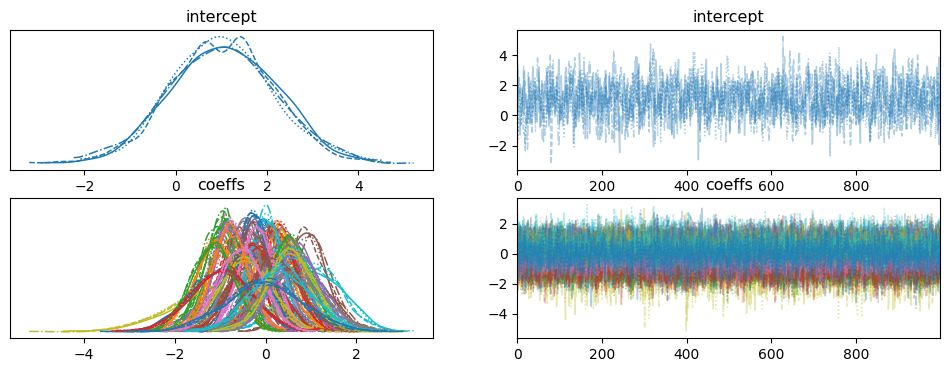

In [32]:
az.plot_trace(trace_logistic_model, compact=True)

# Model with factors

In [27]:
X = zone_entries_BMC_5.iloc[:, 31:]
with pm.Model() as logistic_model:
    # Priors for logistic regression coefficients
    intercept = pm.Normal('intercept', mu=0, sigma=5)
    coeffs = pm.Normal('coeffs', mu=0, sigma=2, shape=X.shape[1])

    # Logistic regression link
    logits = intercept + pm.math.dot(X.values, coeffs)

    # Likelihood
    outcome = pm.Bernoulli('outcome', logit_p=logits, observed=zone_entries['zone_entry_success'].values)

    # Sampling
    trace_logistic_model_5 = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, coeffs]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 292 seconds.


array([[<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'coeffs'}>,
        <Axes: title={'center': 'coeffs'}>]], dtype=object)

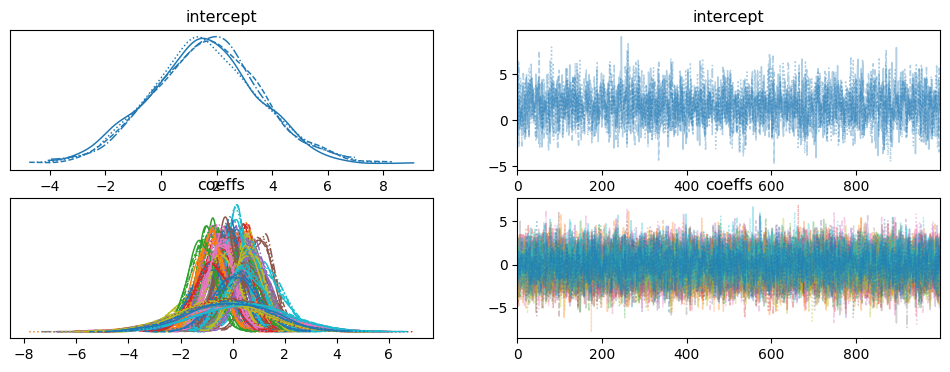

In [28]:
az.plot_trace(trace_logistic_model_5, compact=True)

In [29]:
az.summary(trace_logistic_model_5, var_names=['coeffs'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
coeffs[0],0.113,0.468,-0.750,1.006,0.013,0.009,1327.0,2171.0,1.00
coeffs[1],0.480,0.465,-0.376,1.377,0.014,0.010,1171.0,1803.0,1.00
coeffs[2],-0.780,0.451,-1.559,0.096,0.015,0.011,908.0,1666.0,1.01
coeffs[3],-0.596,0.511,-1.568,0.372,0.013,0.009,1509.0,2254.0,1.00
coeffs[4],-0.548,0.781,-2.020,0.930,0.016,0.011,2352.0,2320.0,1.00
...,...,...,...,...,...,...,...,...,...
coeffs[56],-0.123,1.835,-3.603,3.229,0.030,0.027,3837.0,2862.0,1.00
coeffs[57],-0.389,1.710,-3.677,2.730,0.033,0.025,2704.0,2924.0,1.00
coeffs[58],-0.482,1.590,-3.387,2.546,0.032,0.023,2513.0,2840.0,1.00
coeffs[59],0.375,1.670,-2.637,3.653,0.031,0.024,2834.0,2734.0,1.00


In [ ]:
import pymc as pm
import numpy as np

num_players = players_only.shape[1]  # Number of players
num_factors = 5  # Number of latent factors derived from Poisson factorization
offending_players = ...  # Binary indicators [rows x num_players] for offending players
defending_players = ...  # Binary indicators [rows x num_players] for defending players
latent_factors_offense = ...  # Latent factors associated with offense [rows x num_factors]
latent_factors_defense = ...  # Latent factors associated with defense [rows x num_factors]
success = ...  # Binary outcomes of zone entries [rows x 1]

with pm.Model() as zone_entry_model:
    # Global intercept
    intercept = pm.Flat('intercept')
    
    # Hyperpriors for the standard deviations of player strengths
    sd_offense = pm.HalfCauchy('sd_offense', beta=2.5)
    sd_defense = pm.HalfCauchy('sd_defense', beta=2.5)
    
    # Player strength parameters as random effects
    player_strength_offense = pm.Normal('player_strength_offense', 0, sd_offense, shape=num_players)
    player_strength_defense = pm.Normal('player_strength_defense', 0, sd_defense, shape=num_players)
    
    # Latent factor weights
    factor_weight_offense = pm.Normal('factor_weight_offense', 0, 2, shape=num_factors)
    factor_weight_defense = pm.Normal('factor_weight_defense', 0, 2, shape=num_factors)
    
    # Linear combination of player indicators and latent factors
    logit_p = pm.invlogit(intercept + pm.math.dot(offending_players, player_strength_offense) - pm.math.dot(defending_players, player_strength_defense) + pm.math.dot(latent_factors_offense, factor_weight_offense) - pm.math.dot(latent_factors_defense, factor_weight_defense))
    
    # Model likelihood
    observed_success = pm.Bernoulli('observed_success', logit_p=logit_p, observed=success)


####################################################################################################

In [ ]:
def discrepancy_function(zone_entry_factors,player_factors, data, mask, num_heldout):
    data = np.array(data)
    # Initialize the array to store the observed log probability
    observed_log_prob = np.zeros([zone_entry_factors.shape[1],zone_entry_factors.shape[0]]) # zone entries x num samples

    for i in range(zone_entry_factors.shape[0]):
        # Calculate the rate matrix
        rate = np.dot(zone_entry_factors[i], player_factors[i].T)
        
        # Calculate the log probability of the held-out data under the model
        held_out_rate = rate[~mask].reshape(rate.shape[0], num_heldout)
        held_out_data = data[~mask].reshape(data.shape[0], num_heldout)
        
        observed_log_prob[:,i] = stats.poisson.logpmf(held_out_data, held_out_rate).sum(axis=1)
        
    # Compute the discrepancy function for the actual held-out data
    discrepancy = np.mean(observed_log_prob, axis=1)
    
    return discrepancy

In [220]:
import numpy as np

# Set the random seed for reproducibility
np.random.seed(2)
num_mask = 3
# Example mask creation (conceptual, adjust as needed)
mask = np.ones_like(players_only, dtype=bool)
for i in range(players_only.shape[0]):
    mask_indices = np.random.choice(players_only.shape[1], num_mask, replace=False)
    mask[i, mask_indices] = False


In [221]:
import pymc as pm

with pm.Model() as poisson_factorization:

    # Priors for the factors
    zone_entry_factors = pm.Gamma('zone_entry_factors', alpha=1, beta=1, shape=(players_only.shape[0], 2))
    player_factors = pm.Gamma('player_factors', alpha=1, beta=1, shape=(players_only.shape[1], 2))

    # Expected value parameter for the Poisson likelihood
    rate = pm.math.dot(zone_entry_factors, player_factors.T)

    # Poisson likelihood for the observed data
    observed_counts = pm.Poisson('observed_counts', mu=rate[mask], observed=np.array(players_only)[mask])

    # Sampling
    trace_held_out = pm.sample(return_inferencedata=True)
    


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [zone_entry_factors, player_factors]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 96 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [222]:
zone_entry_factors = trace_held_out.posterior["zone_entry_factors"].values
player_factors = trace_held_out.posterior["player_factors"].values

# Calculate the new shape for the array after flattening the first axis
new_shape = (-1,) + zone_entry_factors.shape[2:]
new_shapepf = (-1,) + player_factors.shape[2:]
# Reshape the array to flatten only the first two axes (chains and draws)
zone_entry_factors = zone_entry_factors.reshape(new_shape)
player_factors = player_factors.reshape(new_shapepf)


In [223]:

# Number of posterior samples (combined from all chains)
n_samples = zone_entry_factors.shape[0]

# Initialize an array to store the predicted counts for the held-out data
predicted_counts_held_out = np.zeros((n_samples, players_only.shape[0], players_only.shape[1]))

# Calculate the rates using the latent factors and sample from the Poisson for each sample
for i in range(n_samples):
    # Compute the rate for this sample
    rate = np.dot(zone_entry_factors[i], player_factors[i].T)
    
    # Sample from a Poisson distribution with the computed rates for the held-out data
    predicted_counts_held_out[i] = np.random.poisson(rate)




In [224]:
actual_discrepancy = discrepancy_function(zone_entry_factors,player_factors, players_only, mask, num_mask)
num_iter = 100
replicated_discrepancy = np.zeros((players_only.shape[0],num_iter))
for i in range(num_iter):
    print(i, end='\r')
    replicated_discrepancy[:,i] = discrepancy_function(zone_entry_factors,player_factors, predicted_counts_held_out[i], mask, num_mask)

In [225]:
# Calculate the prediction score
score = np.mean(replicated_discrepancy < actual_discrepancy[:, np.newaxis], axis =1)

# Print the result
print(np.mean(score))


0.3065925925925926


In [231]:
with pm.Model() as poisson_factorization:

    # Priors for the factors
    zone_entry_factors = pm.Gamma('zone_entry_factors', alpha=1, beta=1, shape=(players_only.shape[0], 20))
    player_factors = pm.Gamma('player_factors', alpha=1, beta=1, shape=(players_only.shape[1], 20))

    # Expected value parameter for the Poisson likelihood
    rate = pm.math.dot(zone_entry_factors, player_factors.T)

    # Poisson likelihood for the observed data
    observed_counts = pm.Poisson('observed_counts', mu=rate[mask], observed=np.array(players_only)[mask])

    # Sampling
    trace_held_out = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [zone_entry_factors, player_factors]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 333 seconds.


In [232]:
zone_entry_factors = trace_held_out.posterior["zone_entry_factors"].values
player_factors = trace_held_out.posterior["player_factors"].values

# Calculate the new shape for the array after flattening the first axis
new_shape = (-1,) + zone_entry_factors.shape[2:]
new_shapepf = (-1,) + player_factors.shape[2:]
# Reshape the array to flatten only the first two axes (chains and draws)
zone_entry_factors = zone_entry_factors.reshape(new_shape)
player_factors = player_factors.reshape(new_shapepf)

In [233]:
# Number of posterior samples (combined from all chains)
n_samples = zone_entry_factors.shape[0]

# Initialize an array to store the predicted counts for the held-out data
predicted_counts_held_out = np.zeros((n_samples, players_only.shape[0], players_only.shape[1]))

# Calculate the rates using the latent factors and sample from the Poisson for each sample
for i in range(n_samples):
    # Compute the rate for this sample
    rate = np.dot(zone_entry_factors[i], player_factors[i].T)
    
    # Sample from a Poisson distribution with the computed rates for the held-out data
    predicted_counts_held_out[i] = np.random.poisson(rate)


In [234]:
actual_discrepancy = discrepancy_function(zone_entry_factors,player_factors, players_only, mask, num_mask)
num_iter = 100
replicated_discrepancy = np.zeros((players_only.shape[0],num_iter))
for i in range(num_iter):
    print(i, end='\r')
    replicated_discrepancy[:,i] = discrepancy_function(zone_entry_factors,player_factors, predicted_counts_held_out[i], mask, num_mask)

In [235]:
# Calculate the prediction score
score = np.mean(replicated_discrepancy < actual_discrepancy[:, np.newaxis], axis =1)

# Print the result
print(np.mean(score))


0.3577222222222223


0.36


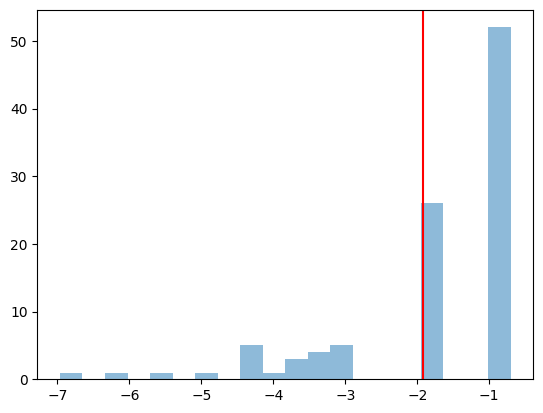

In [243]:
plt.hist(replicated_discrepancy[8], bins=20, alpha=0.5, label='Replicated Discrepancy')
plt.axvline(actual_discrepancy[8], color='red', label='Actual Discrepancy')
print(score[8])